In [122]:
%matplotlib notebook
import lightkurve as lk
import matplotlib.pyplot as plt
import scipy
lcflist = lk.search_lightcurvefile('TIC 374858533').download_all()


<IPython.core.display.Javascript object>


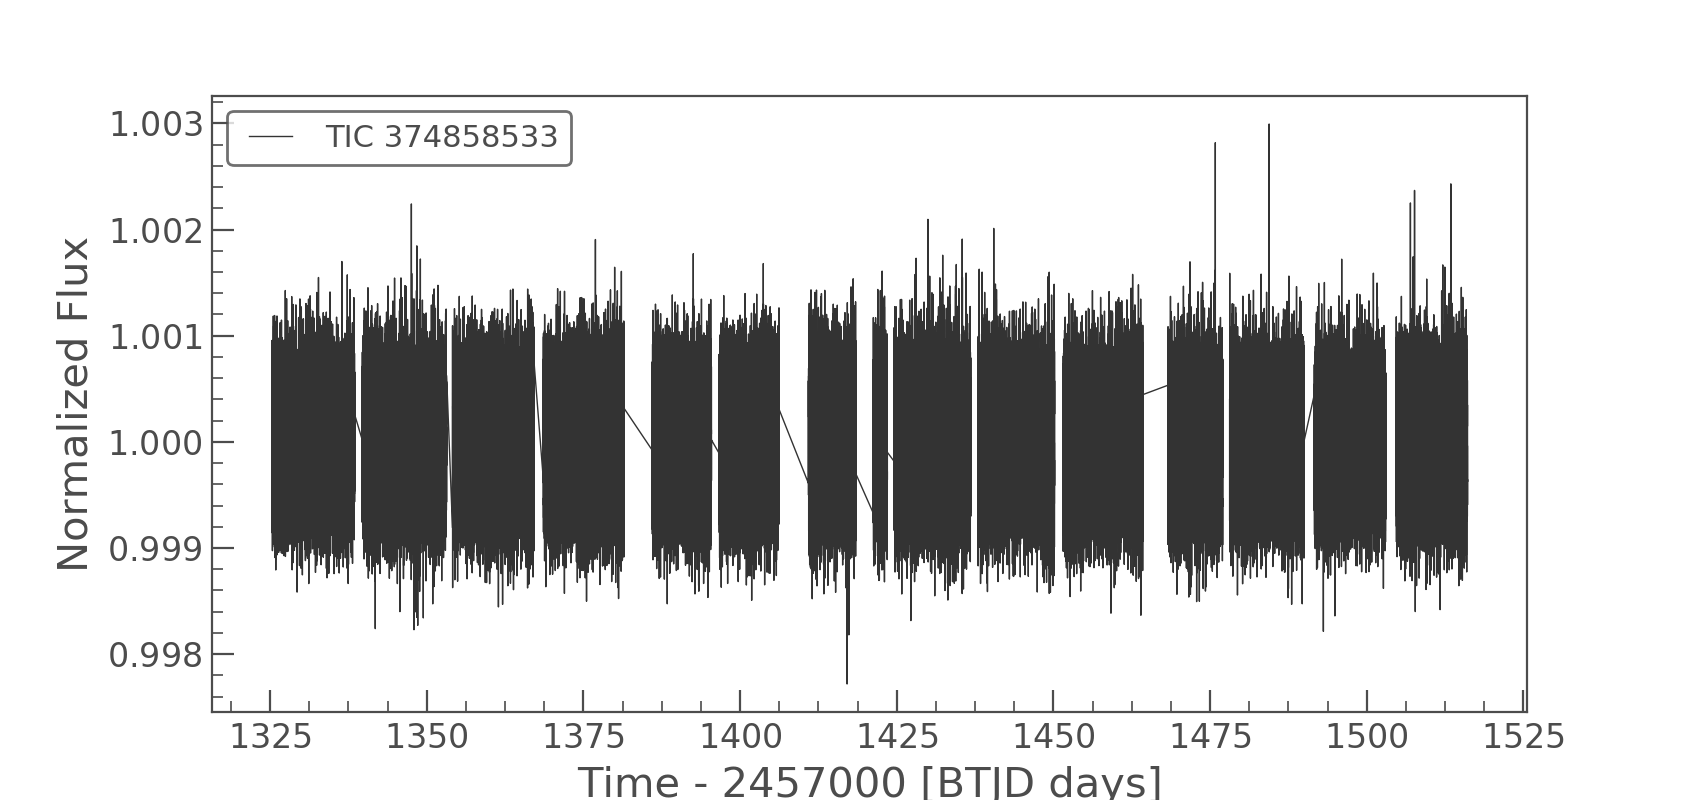

In [123]:
lc = lcflist[0].PDCSAP_FLUX.normalize().flatten(window_length=201,break_tolerance=10)
for value in lcflist[1:]:
    lc = lc.append(value.PDCSAP_FLUX.normalize().flatten(window_length=201,break_tolerance=10))
    
lc.plot()

In [26]:
lc = lk.search_lightcurvefile('TIC 179575669', sector=1).download().PDCSAP_FLUX.normalize()
for q in range(2,7):
    try:
        lc = lc.append(lk.search_lightcurvefile('TIC 179575669', sector=q).download().PDCSAP_FLUX.normalize())
    except:
        pass
lc.plot()

/Users/shishir/anaconda2/envs/py36/lib/python3.6/site-packages/lightkurve/search.py:136: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


AttributeError: 'NoneType' object has no attribute 'PDCSAP_FLUX'

<IPython.core.display.Javascript object>


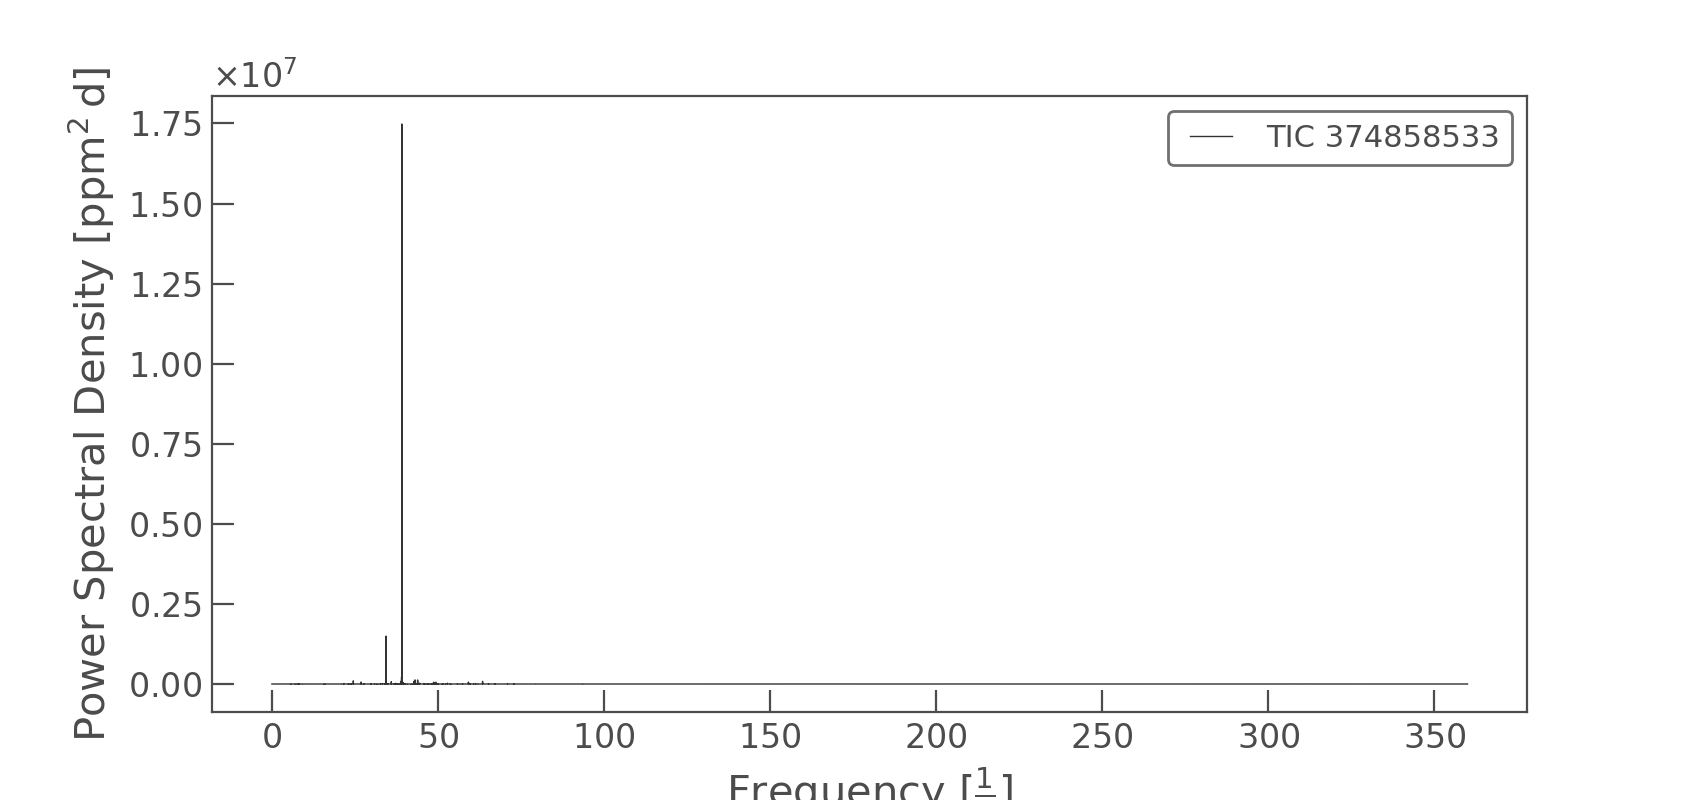

<IPython.core.display.Javascript object>


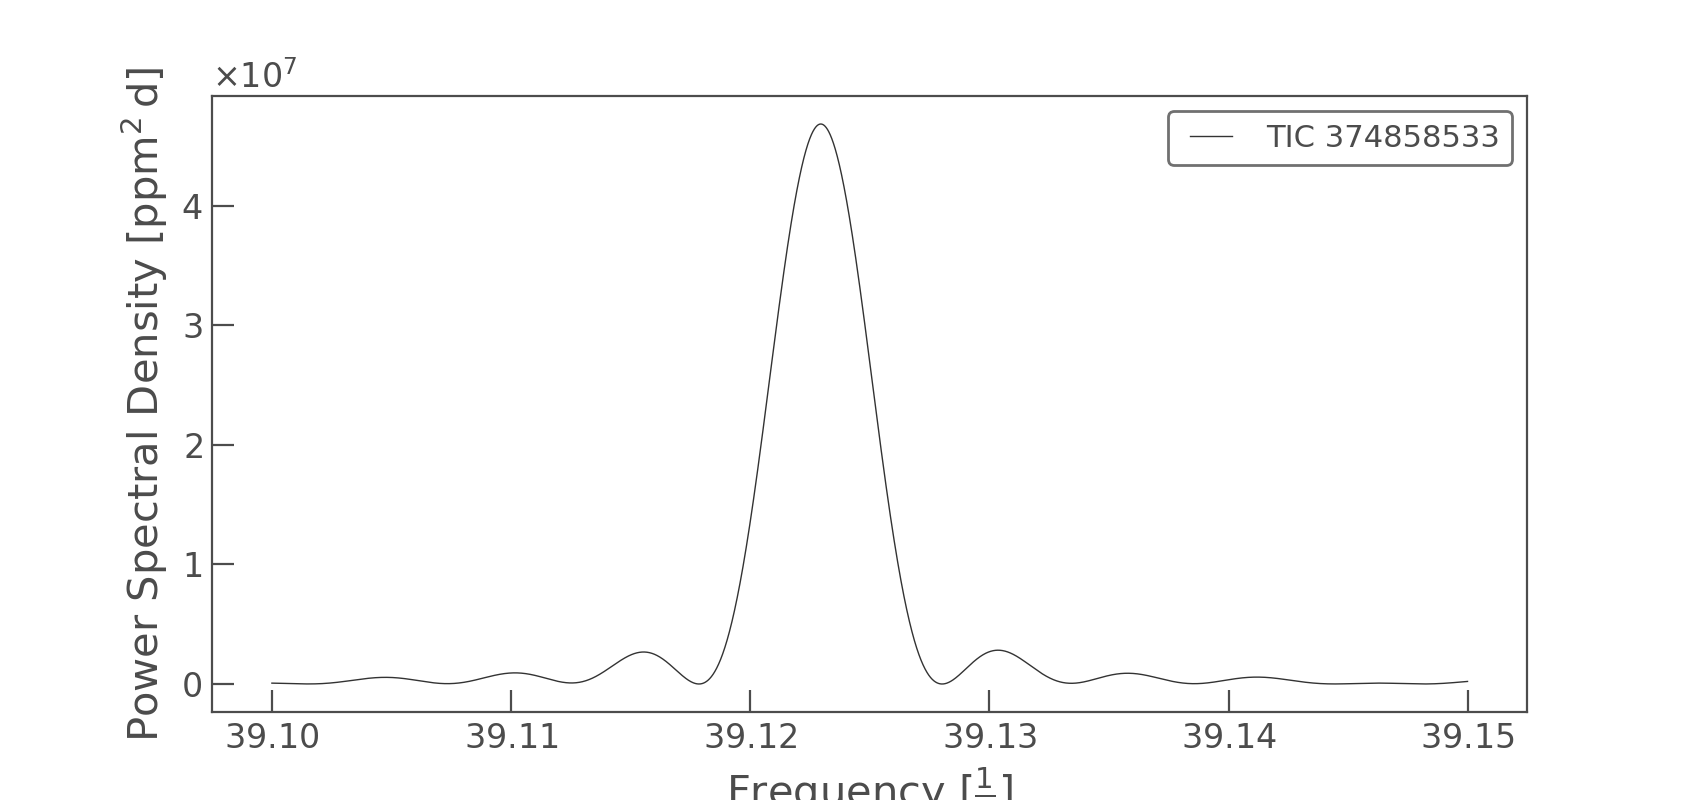

In [126]:
pg1 = lc.remove_nans().to_periodogram()
pg1.plot()
pg = lc.remove_nans().to_periodogram(min_frequency = 39.1, max_frequency = 39.15, oversample_factor = 500, nyquist_factor = 4)
pg.plot()


<IPython.core.display.Javascript object>


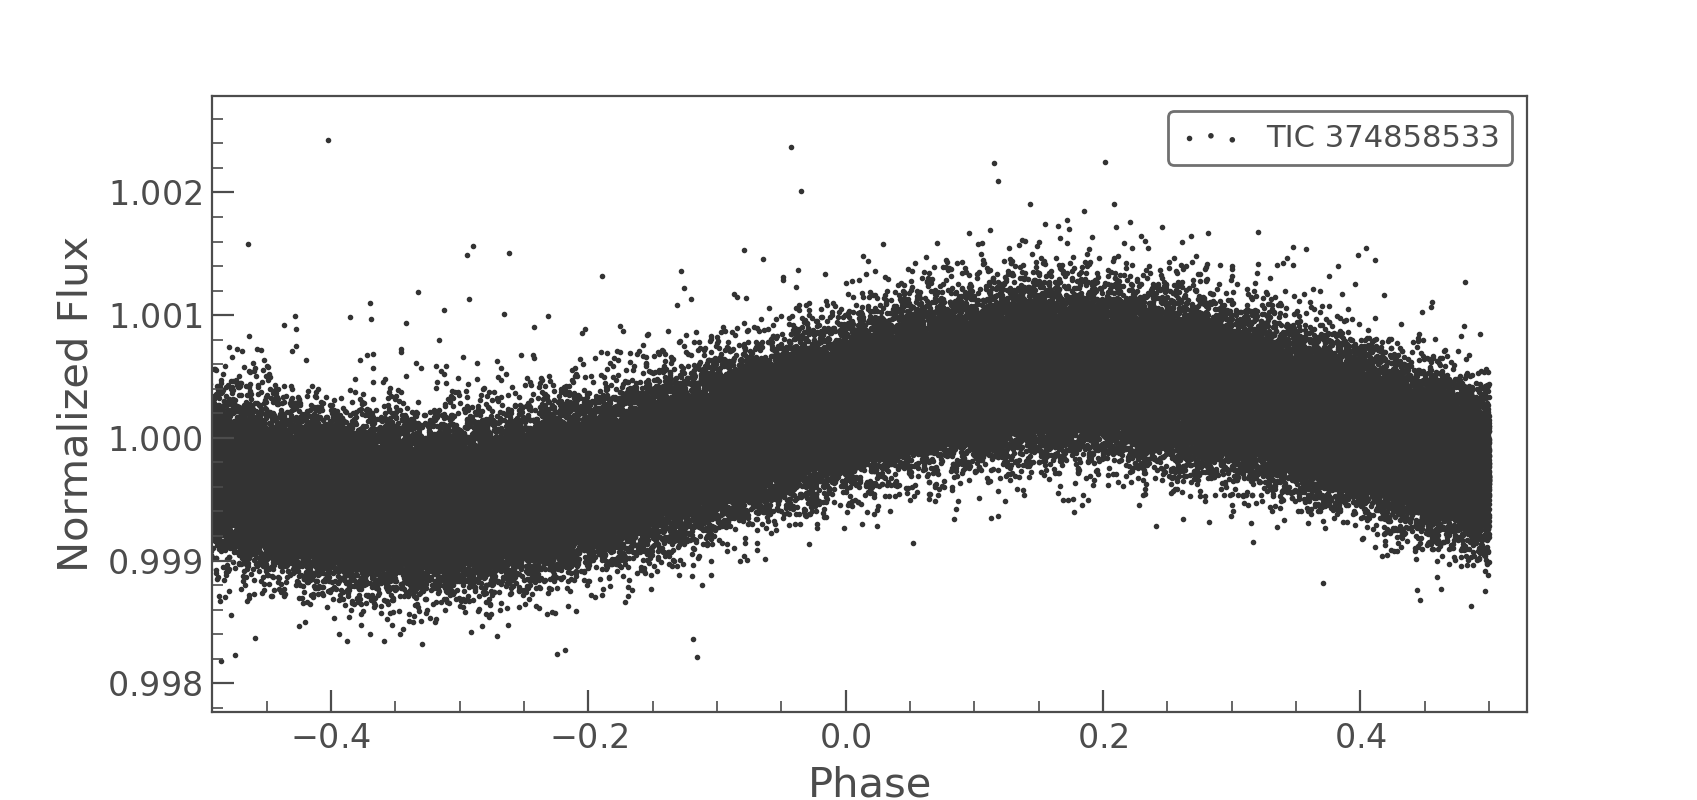

In [127]:
lc.fold(pg.period_at_max_power.value).scatter()
freq=pg.frequency_at_max_power.value

In [109]:
def divide_chunks(l, n): 
  
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n]

In [110]:
def sinfunc(t,p, A):  return A * np.sin(2.*np.pi*freq*(t + p)) + 1.0
print(freq)

6.730834145042061


<IPython.core.display.Javascript object>


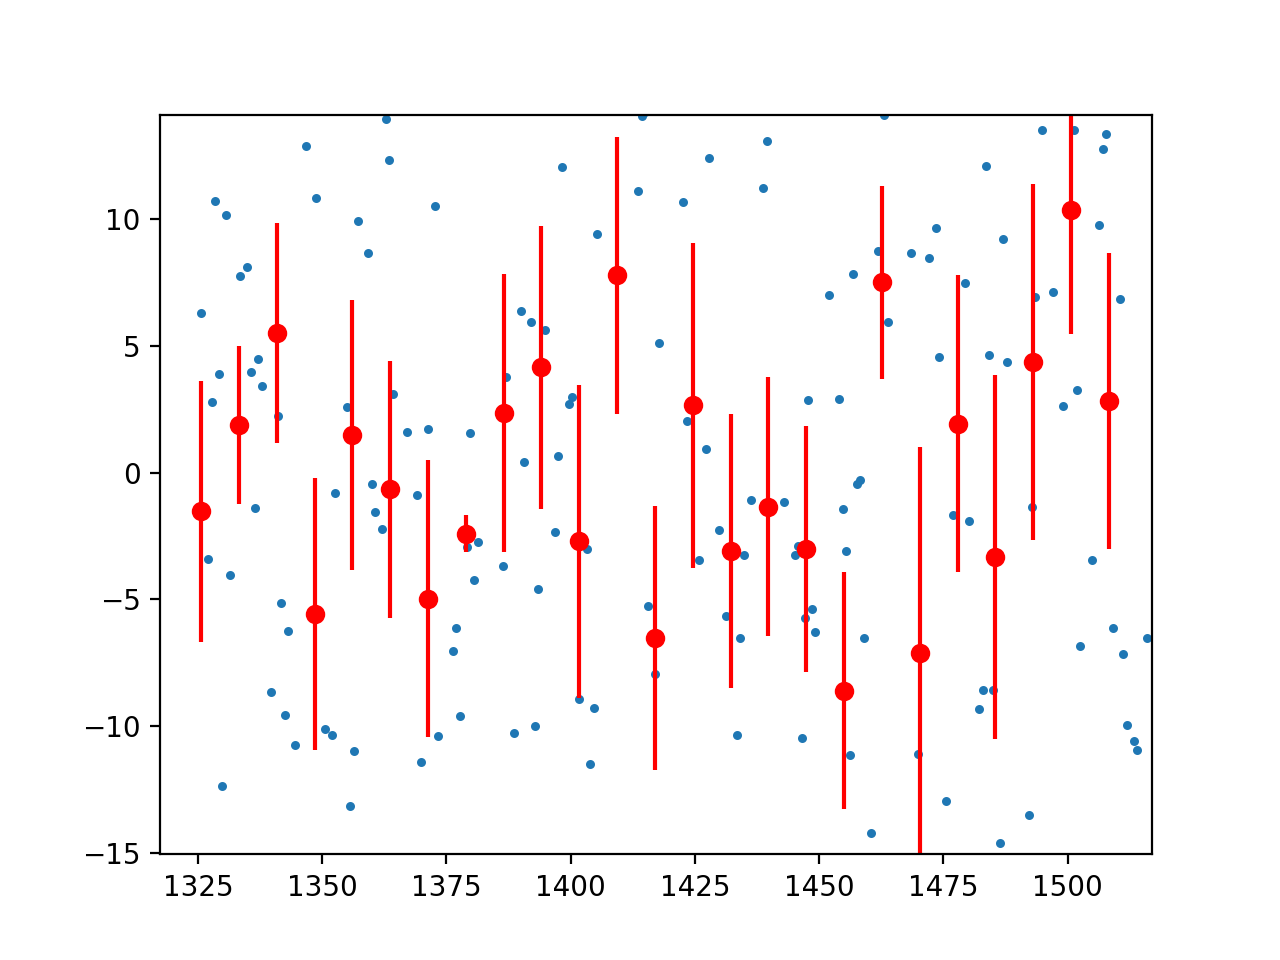

<Container object of 3 artists>

In [142]:
import numpy as np
lc = lc.remove_nans()
guess_amp = np.std(lc.flux) * 2.**0.5
num_sections = 500
time = list(divide_chunks(lc.time,num_sections))
flux = list(divide_chunks(lc.flux,num_sections))
import numpy as np
periodlist = []
mediantimelist = []
#iterate over every window
for index, interval in enumerate(time):
    guess = np.array([1325.31,guess_amp])
    popt, pcov = scipy.optimize.curve_fit(sinfunc, interval, flux[index], p0=guess)
    periodlist.append(popt[0])
    mediantimelist.append(np.median(interval))
fig = plt.figure()
ax = fig.add_subplot(111)

arr = scipy.stats.binned_statistic(mediantimelist, periodlist, 'mean', bins=25)
arr1 = scipy.stats.binned_statistic(mediantimelist, periodlist, np.std, bins=25)

ax.scatter(np.array(mediantimelist),86400*(np.array(periodlist)-np.mean(periodlist)),s=5)
ax.errorbar(arr[1][0:-1],(np.array(arr[0])-np.mean(periodlist))*86400,yerr = (arr1[0]*86400.0)/np.sqrt(arr[1][1]-arr[1][0]),fmt = 'o', c='red')